# TP : Implémentation d'un réseau de neurones de type Perceptron multicouche pour un problème de classification
Dans ce TP, vous allez implémenter en Numpy un réseau de neurones de type Perceptron multicouche.


## Configuration
### Si vous utilisez un ordinateur de l'Enseirb:
#### 1) Lancer une session linux (et non pas windows)
#### 2) Aller dans "Applications", puis "Autre", puis "conda_pytorch" (un terminal devrait s'ouvrir)
#### 3) Dans ce terminal, taper la commande suivante pour lancer Spyder :  
`spyder &`  
### Si vous utilisez votre ordinateur personnel, il faudra installer Spyder.  

---
---
## Ne pas oublier de configurer Spyder en suivant ces [instructions](https://gbourmaud.github.io/files/configuration_spyder_annotated.pdf).
---
---

Le fichier [utils.py](https://gbourmaud.github.io/files/intro_deep_learning/TP/TP_MLP/utils.py) contient des fonctions qui seront utilisées par la suite.

### Créer un nouveau script python et copiez/collez le code suivant :

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import utils

np.random.seed(0)

### Définition d'un exemple jouet à 3 classes en 2D :

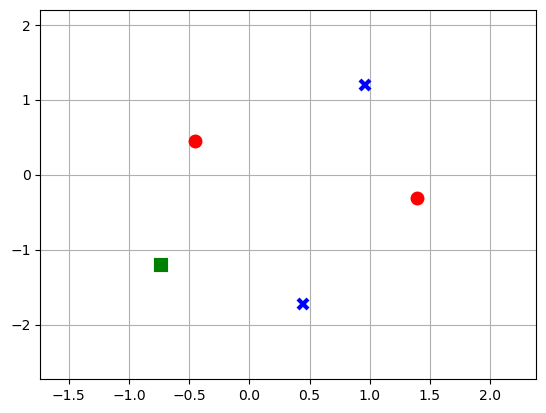

In [19]:
#%% DEFINE AND PLOT DATA
    
style_per_class = ['xb', 'or', 'sg']
X = np.array([[1.2, 2.3, -0.7, 3.2, -1.3],[-3.4, 2.8, 1.2, -0.4, -2.3]]).T
X -= X.mean() #centering data (globally)
X /= X.std() #reduce data (globally)
y = np.array([0,0,1,1,2])

C = len(style_per_class)
N = X.shape[0]
xx, yy = utils.make_meshgrid(X[:,0], X[:,1], h=0.01)


fig1, axs1 = plt.subplots(1)
axs1.set_xlim(xx.min(), xx.max())
axs1.set_ylim(yy.min(), yy.max())
axs1.grid(True)

for i in range(C):
    x_c = X[y==i,:]
    axs1.plot(x_c[:,0],x_c[:,1],style_per_class[i],markersize=7, markeredgewidth=3.)

plt.pause(0.1)

## Implémentation des fonctions $\text{FC}$, $\widetilde{\text{FC}}$, $\text{ReLU}$ et $\widetilde{\text{ReLU}}$

In [20]:
def FC_forward(X,W,b):
    Z = X.dot(W) + b #NxH
    return Z

def FC_backward(dc_dZ, X, W, b):
    dc_dX = 0 #TODO compute dc_dX (one line)
    dc_dW = 0 #TODO compute dc_dW (one line)
    dc_db = 0 #TODO compute dc_db (one line)
    return dc_dX, dc_dW, dc_db

def relu_forward(X):
    Z = np.maximum(0.,X) 
    return Z

def relu_backward(dc_dZ, X):
    dc_dX = 0 #TODO compute dc_dX (two lines)
    return dc_dX
    

**Travail : implémenter les fonctions `FC_backward` et  `relu_backward` en utilisant les équations obtenues en TP. Le code ci-après permet de tester vos implémentations.**

In [ ]:
def test_FC_backward():
    
    eta = 1e-5
    N = 100
    D = 10
    H = 20
    X = np.random.normal(size=(N,D))
    dX = np.random.normal(size=(N,D))
    W = np.random.normal(size=(D,H))
    b = np.random.normal(size=(H))
    dW = np.random.normal(size=(D,H))
    db = np.random.normal(size=(H))


    ddX_approx = (FC_forward(X+eta*dX,W,b).sum() - FC_forward(X,W,b).sum())/eta
    dc_dX, _, _ = FC_backward(np.ones((N,H)), X, W, b)
    ddX = (dc_dX*dX).sum()
    if(np.isclose(ddX,ddX_approx)):
        print('Test FC_backward dl_dX: SUCCESS')
    else:
        print('Test FC_backward dl_dX: FAILURE')
        sys.exit()
    
    ddW_approx = (FC_forward(X,W+eta*dW,b).sum() - FC_forward(X,W,b).sum())/eta
    _, dc_dW, _ = FC_backward(np.ones((N,H)), X, W, b)
    ddW = (dc_dW*dW).sum()
    if(np.isclose(ddW,ddW_approx)):
        print('Test FC_backward dl_dW: SUCCESS')
    else:
        print('Test FC_backward dl_dW: FAILURE')
        sys.exit()
    
    ddb_approx = (FC_forward(X,W,b+eta*db).sum() - FC_forward(X,W,b).sum())/eta
    _, _, dc_db = FC_backward(np.ones((N,H)), X, W, b)
    ddb = (dc_db*db).sum()
    if(np.isclose(ddb,ddb_approx)):
        print('Test FC_backward dl_db: SUCCESS')
    else:
        print('Test FC_backward dl_db: FAILURE')
        sys.exit()
    
    return

test_FC_backward()

In [ ]:
def test_relu_backward():
    
    eta = 1e-5
    N = 100
    D = 10
    X = np.random.normal(size=(N,D))
    dX = np.random.normal(size=(N,D))

    ddX_approx = (relu_forward(X+eta*dX).sum() - relu_forward(X).sum())/eta
    dc_dX = relu_backward(np.ones((N,D)), X)
    ddX = (dc_dX*dX).sum()
    if(np.isclose(ddX,ddX_approx)):
        print('Test relu_backward dl_db: SUCCESS')
    else:
        print('Test relu_backward dl_db: FAILURE')
        sys.exit()
    
    return

test_relu_backward()

### Implémentation d'un MLP à une couche cachée :

In [12]:
class MLP:
    def __init__(self, H):

        self.C = 3
        self.D = 2
        self.H = H
        

        #parameters
        self.W1 = (np.sqrt(6./self.D))*(2*(np.random.uniform(size=(self.D,self.H))-0.5))
        self.b1 = (1./np.sqrt(self.D))*(2*(np.random.uniform(size=(self.H))-0.5))
        self.W3 = (np.sqrt(6./self.H))*(2*(np.random.uniform(size=(self.H,self.C))-0.5))
        self.b3 = (1./np.sqrt(self.H))*(2*(np.random.uniform(size=(self.C))-0.5))
        
        #gradients
        self.dc_dW1 = np.zeros_like(self.W1)
        self.dc_db1 = np.zeros_like(self.b1)
        self.dc_dW3 = np.zeros_like(self.W3)
        self.dc_db3 = np.zeros_like(self.b3)
        

        
    def forward(self,X):
    
        X1 = FC_forward(X, self.W1, self.b1) #NxH
        X2 = relu_forward(X1) #NxH
        S = FC_forward(X2, self.W3, self.b3) #NxC
    
        return X,X1,X2,S
    
    def backward(self,dc_dS, S, X2, X1, X0):
        
        dc_dX2, dc_dW3, dc_db3 = FC_backward(dc_dS, X2, self.W3, self.b3)
        self.dc_dW3 += dc_dW3
        self.dc_db3 += dc_db3
        
        dc_dX1 = relu_backward(dc_dX2, X1)
        
        dc_dX0, dc_dW1, dc_db1 = FC_backward(dc_dX1, X0, self.W1, self.b1)
        self.dc_dW1 += dc_dW1
        self.dc_db1 += dc_db1
        
        
        return
        

### Définition de la fonction de coût :

In [13]:
def logsoftmax(x):
    x_shift = x - np.amax(x, axis=1, keepdims=True)
    return x_shift - np.log(np.exp(x_shift).sum(axis=1, keepdims=True))   
    
def softmax(x):
    e_x = np.exp(x - np.amax(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)
    
def crossEntropyLoss(S, y):
    N = y.shape[0]
    P = softmax(S.astype('double'))
    log_p = logsoftmax(S.astype('double'))
    a = log_p[np.arange(N),y]
    l = -a.sum()/N
    dc_dS = P
    dc_dS[np.arange(N),y] -= 1
    dc_dS = dc_dS/N
    return (l, dc_dS)

### Implémentation de la méthode de descente de gradient avec moment :

In [14]:
class GradientDescentWithMomentum:
    def __init__(self, model, beta, lr):
        
        self.model = model
        self.beta= beta
        self.lr = lr
        
        #momentum
        self.VW1 = np.zeros_like(self.model.W1)
        self.Vb1 = np.zeros_like(self.model.b1)
        self.VW3 = np.zeros_like(self.model.W3)
        self.Vb3 = np.zeros_like(self.model.b3)
        
    def step(self):
        self.VW1 = self.beta*self.VW1 + (1.0-self.beta)*self.model.dc_dW1
        self.model.W1 -= self.lr*self.VW1

        self.VW3 = self.beta*self.VW3 + (1.0-self.beta)*self.model.dc_dW3
        self.model.W3 -= self.lr*self.VW3
    
        self.Vb1 = self.beta*self.Vb1 + (1.0-self.beta)*self.model.dc_db1
        self.model.b1 -= self.lr*self.Vb1
    
        self.Vb3 = self.beta*self.Vb3 + (1.0-self.beta)*self.model.dc_db3
        self.model.b3 -= self.lr*self.Vb3
    
    def zero_gradients(self):
        self.model.dc_dW1.fill(0.)
        self.model.dc_db1.fill(0.)
        self.model.dc_dW3.fill(0.)
        self.model.dc_db3.fill(0.)

### Avant de lancer un apprentissage, il faut choisir les hyper-paramètres de l'architecture et de l'algorithme de descente de gradient avec moment

In [15]:
#%% HYPERPARAMETERS
H = 300
lr = 1e-2 #learning rate
beta = 0.9 #momentum parameter

### Création d'une instance du MLP à une couche cachée :

In [16]:
model = MLP(H)

### Création d'une instance de la descente de gradient avec moment

In [17]:
optimizer = GradientDescentWithMomentum(model, beta, lr)

### Nous pouvons lancer l'optimisation :

In [ ]:
it = 0
while 1:    
    #Forward Pass
    X0,X1,X2,S = model.forward(X)
    
    #Compute Loss
    [c, dc_dS] = crossEntropyLoss(S, y)
    
    #Print Loss and Classif Accuracy
    pred = np.argmax(S, axis=1)
    acc = (np.argmax(S, axis=1) == y).astype('float').sum()/N
    print('Iter {} | Training Loss = {} | Training Accuracy = {}%'.format(it,c,acc*100))

    #Backward Pass (Compute Gradient)
    optimizer.zero_gradients()
    model.backward(dc_dS, S, X2, X1, X0)
    
    #Update Parameters
    optimizer.step()
    it += 1
    
    
    if(np.mod(it,10)==0):
        #Plot decision boundary
        axs1.cla()
        for i in range(C):
            x_c = X[y==i,:]
            axs1.plot(x_c[:,0],x_c[:,1],style_per_class[i],markersize=7, markeredgewidth=3.)
        utils.plot_contours(axs1, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
        plt.pause(0.1)


# Travail à effectuer
* Après avoir implémenté la fonction `backward`, vous devriez constater que l'apprentissage sur l'exemple jouet "fonctionne", c'est-à-dire que le coût diminue progressivement vers zéro et le taux de bonne classification atteint rapidement 100%.
* Vous remarquerez que les paramètres du MLP sont initialisés aléatoirement selon une distribution uniforme centrée en zéro appelée "Initialisation de Kaiming". Remplacer cette initialisation en initialisant tous les paramètres à zéro. Afficher les valeurs des activations (`X1`, `X2`, `O`) et des dérivées (notamment `dl_dW3` et `dl_dW2`). Que constatez-vous ? Pourquoi ?
* Restaurer l'initialisation aléatoire des paramètres.
* Modifier l'implémentation pour obtenir un MLP à 2 couches cachées (rajouter une transformation affine et une ReLU au MLP actuel).
* Modifier l'implémentation pour la rendre générique de telle sorte que le nombre de couches cachées soit un hyper-paramètre réglable.